In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size
from matplotlib.transforms import Bbox
import seaborn as sns
import scanpy as sc
import scipy
import sklearn
import torch
import scvi
import time
from scvi.external import CellAssign
from sklearn.model_selection import train_test_split
from importlib import reload

# locals
import utils as ut
import plotting as plt2

In [2]:
print(torch.version.cuda) 

12.0


In [3]:
# Check CUDA availability
cuda_available = torch.cuda.is_available()
print(f"CUDA available: {cuda_available}")

if cuda_available:
    num_gpus = torch.cuda.device_count()
    print(f"Number of GPUs: {num_gpus}")

    for i in range(num_gpus):
        gpu_name = torch.cuda.get_device_name(i)
        print(f"GPU {i}: {gpu_name}")

        # Additional information (compute capability, memory)
        gpu_props = torch.cuda.get_device_properties(i)
        print(f"  Compute Capability: {gpu_props.major}.{gpu_props.minor}")
        print(f"  Total Memory: {gpu_props.total_memory / 1024**3:.2f} GB")
else:
    print("CUDA not available. Running on CPU.")

CUDA available: True
Number of GPUs: 1
GPU 0: NVIDIA A100 80GB PCIe MIG 3g.40gb
  Compute Capability: 8.0
  Total Memory: 39.25 GB


# Load Data

In [4]:
# fpath = "/scratch/indikar_root/indikar1/cstansbu/HSC/scanpy/hsc_landscape.anndata.h5ad"
fpath = "/scratch/indikar_root/indikar1/cstansbu/hematokytos/merged_anndata/merged_adata.h5ad"

adata = sc.read_h5ad(fpath)
adata.X = adata.layers['counts'].copy()
sc.logging.print_memory_usage()

lib_size = adata.X.sum(1)
adata.obs["size_factor"] = lib_size / np.mean(lib_size)

adata

Memory usage: current 8.69 GB, difference +8.69 GB


AnnData object with n_obs × n_vars = 171498 × 18867
    obs: 'n_genes', 'dataset', 'n_genes_by_counts', 'total_counts', 'size_factor'
    var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'gene_id', 'token_id', 'gene_biotype', 'Chromosome', 'Start', 'End'
    layers: 'counts'

In [5]:
adata.obs['dataset'].value_counts()

dataset
weng_young2_all        29289
tabula_sapiens         27313
weng_young1_all_t2     25317
pellin                 19180
weng_young1_all_t1     18499
weng_old2_BMMC_HSPC    17292
weng_old1_BMMC_HSPC    14790
iHSC                    8379
sc_fib                  7736
weng_young2_HSC         3703
Name: count, dtype: int64

# Add cell type annotations

In [6]:
fpath = "/scratch/indikar_root/indikar1/cstansbu/hematokytos/annotation/cell_types.csv"

def load_annotations(fpath):
    """
    Loads annotations data from a CSV file, processes it, and returns the resulting DataFrame.

    Args:
        fpath (str): The file path to the CSV file containing annotations data.

    Returns:
        pd.DataFrame: The processed DataFrame with 'cell_id' as the index.
    """
    df = pd.read_csv(fpath)
    df['cell_id'] = df['obs_index'].astype(str) + "_" + df["dataset"]
    df = df.drop(columns='dataset')
    df = df.set_index('cell_id')
    return df

df = load_annotations(fpath)

print(f"\nMerging annotations...")
adata.obs = pd.merge(
    adata.obs,
    df,
    how='left',
    left_index=True,
    right_index=True,
)

adata.obs.head()


Merging annotations...


,n_genes,dataset,n_genes_by_counts,total_counts,size_factor,obs_index,cell_type,standard_cell_type
PreBNK_AGTTGAAC-TTGCATAT_1_pellin,2637,pellin,2633,13711.738192,0.949161,PreBNK_AGTTGAAC-TTGCATAT_1,PreBNK,PreBNK
PreBNK_AATCCGGC-TGAAATGA_1_pellin,1144,pellin,1142,7140.276133,0.301382,PreBNK_AATCCGGC-TGAAATGA_1,PreBNK,PreBNK
PreBNK_CAAACATT-TCTGTGGT_1_pellin,877,pellin,873,5812.409500,0.194820,PreBNK_CAAACATT-TCTGTGGT_1,PreBNK,PreBNK
PreBNK_CGTGTACA-TTCCAGAC_1_pellin,2233,pellin,2232,11925.223895,0.844374,PreBNK_CGTGTACA-TTCCAGAC_1,PreBNK,PreBNK
PreBNK_CATGACGA-CTTACGGG_1_pellin,951,pellin,948,6039.884097,0.275699,PreBNK_CATGACGA-CTTACGGG_1,PreBNK,PreBNK


In [7]:
adata.obs['cell_type'].value_counts()

cell_type
FB                        26553
HSC                       11693
CD4                       11399
EryP                       9902
MPP                        9391
Refined.HSC                9096
iHSC                       8379
CD8                        7904
sc_fib                     7736
MEP                        7433
Mono                       6988
ProB                       6735
LinNegCD34PosCD164Pos      5992
GMP                        4882
LinNegCD34lowCD164high     4194
NK                         4189
MDP                        3989
MKP                        3980
CLP                        3640
B                          3329
LinNegCD34NegCD164high     3016
CMP                        2804
pDC                        1809
cDC                         885
LMPP                        805
Plasma                      670
PreBNK                      554
LinNegCD34NegCD164low       194
MLP                         123
Name: count, dtype: int64

In [8]:
adata.obs['standard_cell_type'].value_counts()

standard_cell_type
Fib               34289
HSC               20789
T_cell            19303
LinNeg            13396
B_cell            10734
EryP               9902
MPP                9391
iHSC               8379
MEP                7433
Mono               6988
GMP                4882
NK                 4189
MDP                3989
MKP                3980
CLP                3640
CMP                2804
Dendritic_cell     2694
LMPP                805
PreBNK              554
MLP                 123
Name: count, dtype: int64

In [9]:
adata.obs['cell_type'] = adata.obs['standard_cell_type']

# Get features (pangloa)

In [10]:
# fpath = "../resources/PanglaoDB_Augmented_2021.txt"
# feature = ut.load_pathway(fpath) 
# feature.head()

# cell_types = [
#     'Fibroblasts',
#     'Hematopoietic Stem Cells',
# ]

# marker_gene_mat = feature[cell_types].copy()
# marker_gene_mat = marker_gene_mat[marker_gene_mat.index.isin(adata.var_names)]

# print(f"{marker_gene_mat.shape=}")
# marker_gene_mat = marker_gene_mat[marker_gene_mat.sum(axis=1) > 0] 
# print(f"{marker_gene_mat.shape=}")
# marker_gene_mat.head()

# Cell Marker Genes

In [11]:
fpath = "../resources/CellMarker_Augmented_2021.txt"
feature = ut.load_pathway(fpath)  
print(f"{feature.shape=}")

cell_types = [
    'Hematopoietic cell:Liver',
    'Hematopoietic Stem cell:Umbilical Cord Blood',
    'Hematopoietic Progenitor cell:Umbilical Cord Blood',
    'Hematopoietic Stem cell:Bone Marrow',
    'Hematopoietic Stem cell:Breast',
    'Early Hematopoietic cell:Blood',
    'Hematopoietic Stem cell:Peripheral Blood',
    'Hematopoietic cell:Bone Marrow',
    'Hematopoietic Progenitor cell:Bone Marrow',
    'Hematopoietic Stem cell:Corneal Endothelium',
    'Hematopoietic Stem cell:Periodontal Ligament',
    'Hematopoietic cell:Fetal Liver',
    'Hematopoietic Precursor cell:Fetal Liver',
    'Hematopoietic Progenitor cell:Undefined',
    'Hematopoietic Stem cell:Tooth',
    'Hematopoietic Stem cell:Embryo',
    'Hematopoietic cell:Undefined',
    'Hematopoietic Stem cell:Blood',
    'Hematopoietic Stem cell:Germ',
    'Hematopoietic Stem cell:Undefined',
    'Fibroblast:Pancreas',
    'Fibroblast:Undefined',
    'Fibroblast:Synovium',
    'Fibroblast:Vocal Fold',
    'Fibroblast:Corneal Endothelium',
    'Fibroblast:Embryonic Stem Cell',
    'Myofibroblast:Liver',
    'Fibroblast:Lung',
    'Myofibroblast:Undefined',
    'Myofibroblast:Lung',
    'Fibroblast:Peripheral Blood',
    'Fibroblast:Heart',
]


marker_gene_mat = feature[cell_types].copy()
marker_gene_mat = marker_gene_mat[marker_gene_mat.index.isin(adata.var_names)]

print(f"{marker_gene_mat.shape=}")
marker_gene_mat = marker_gene_mat[marker_gene_mat.sum(axis=1) > 0] 
print(f"{marker_gene_mat.shape=}")
marker_gene_mat.head()


feature.shape=(14167, 1097)
marker_gene_mat.shape=(13347, 32)
marker_gene_mat.shape=(955, 32)


label,Hematopoietic cell:Liver,Hematopoietic Stem cell:Umbilical Cord Blood,Hematopoietic Progenitor cell:Umbilical Cord Blood,Hematopoietic Stem cell:Bone Marrow,Hematopoietic Stem cell:Breast,Early Hematopoietic cell:Blood,Hematopoietic Stem cell:Peripheral Blood,Hematopoietic cell:Bone Marrow,Hematopoietic Progenitor cell:Bone Marrow,Hematopoietic Stem cell:Corneal Endothelium,...,Fibroblast:Synovium,Fibroblast:Vocal Fold,Fibroblast:Corneal Endothelium,Fibroblast:Embryonic Stem Cell,Myofibroblast:Liver,Fibroblast:Lung,Myofibroblast:Undefined,Myofibroblast:Lung,Fibroblast:Peripheral Blood,Fibroblast:Heart
CD2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
JAML,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
CD69,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
GIMAP1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
SLA,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


# Get Features (tabula)

In [12]:
# fpath = "../resources/Tabula_Sapiens.txt"
# feature = ut.load_pathway(fpath)  
# print(f"{feature.shape=}")

# cell_types = [
#     'Bladder-fibroblast',
#     'Large Intestine-fibroblast',
#     'Lung-fibroblast',
#     'Small Intestine-fibroblast',
#     'Thymus-fibroblast',
#     'Vasculature-fibroblast',
#     'Mammary-fibroblast Of Breast',
#     'Uterus-fibroblast',
#     'Eye-fibroblast',
#     'Liver-fibroblast',
#     'Trachea-fibroblast',
#     'Salivary Gland-fibroblast',
#     'Tongue-fibroblast',
#     'Prostate-fibroblast',
#     'Pancreas-fibroblast',
#     'Fat-fibroblast',
#     'Blood-hematopoietic Stem Cell',
#     'Bone Marrow-hematopoietic Stem Cell',
#     'Lymph Node-hematopoietic Stem Cell',
#     'Spleen-hematopoietic Stem Cell',
#     # 'Fat-mesenchymal Stem Cell',
#     # 'Muscle-mesenchymal Stem Cell',
#     # 'Muscle-skeletal Muscle Satellite Stem Cell',
# ]


# marker_gene_mat = feature[cell_types].copy()
# marker_gene_mat = marker_gene_mat[marker_gene_mat.index.isin(adata.var_names)]

# print(f"{marker_gene_mat.shape=}")
# marker_gene_mat = marker_gene_mat[marker_gene_mat.sum(axis=1) > 0] 
# print(f"{marker_gene_mat.shape=}")
# marker_gene_mat.head()

pdf.shape=(953, 32)


Text(0, 0.5, '')

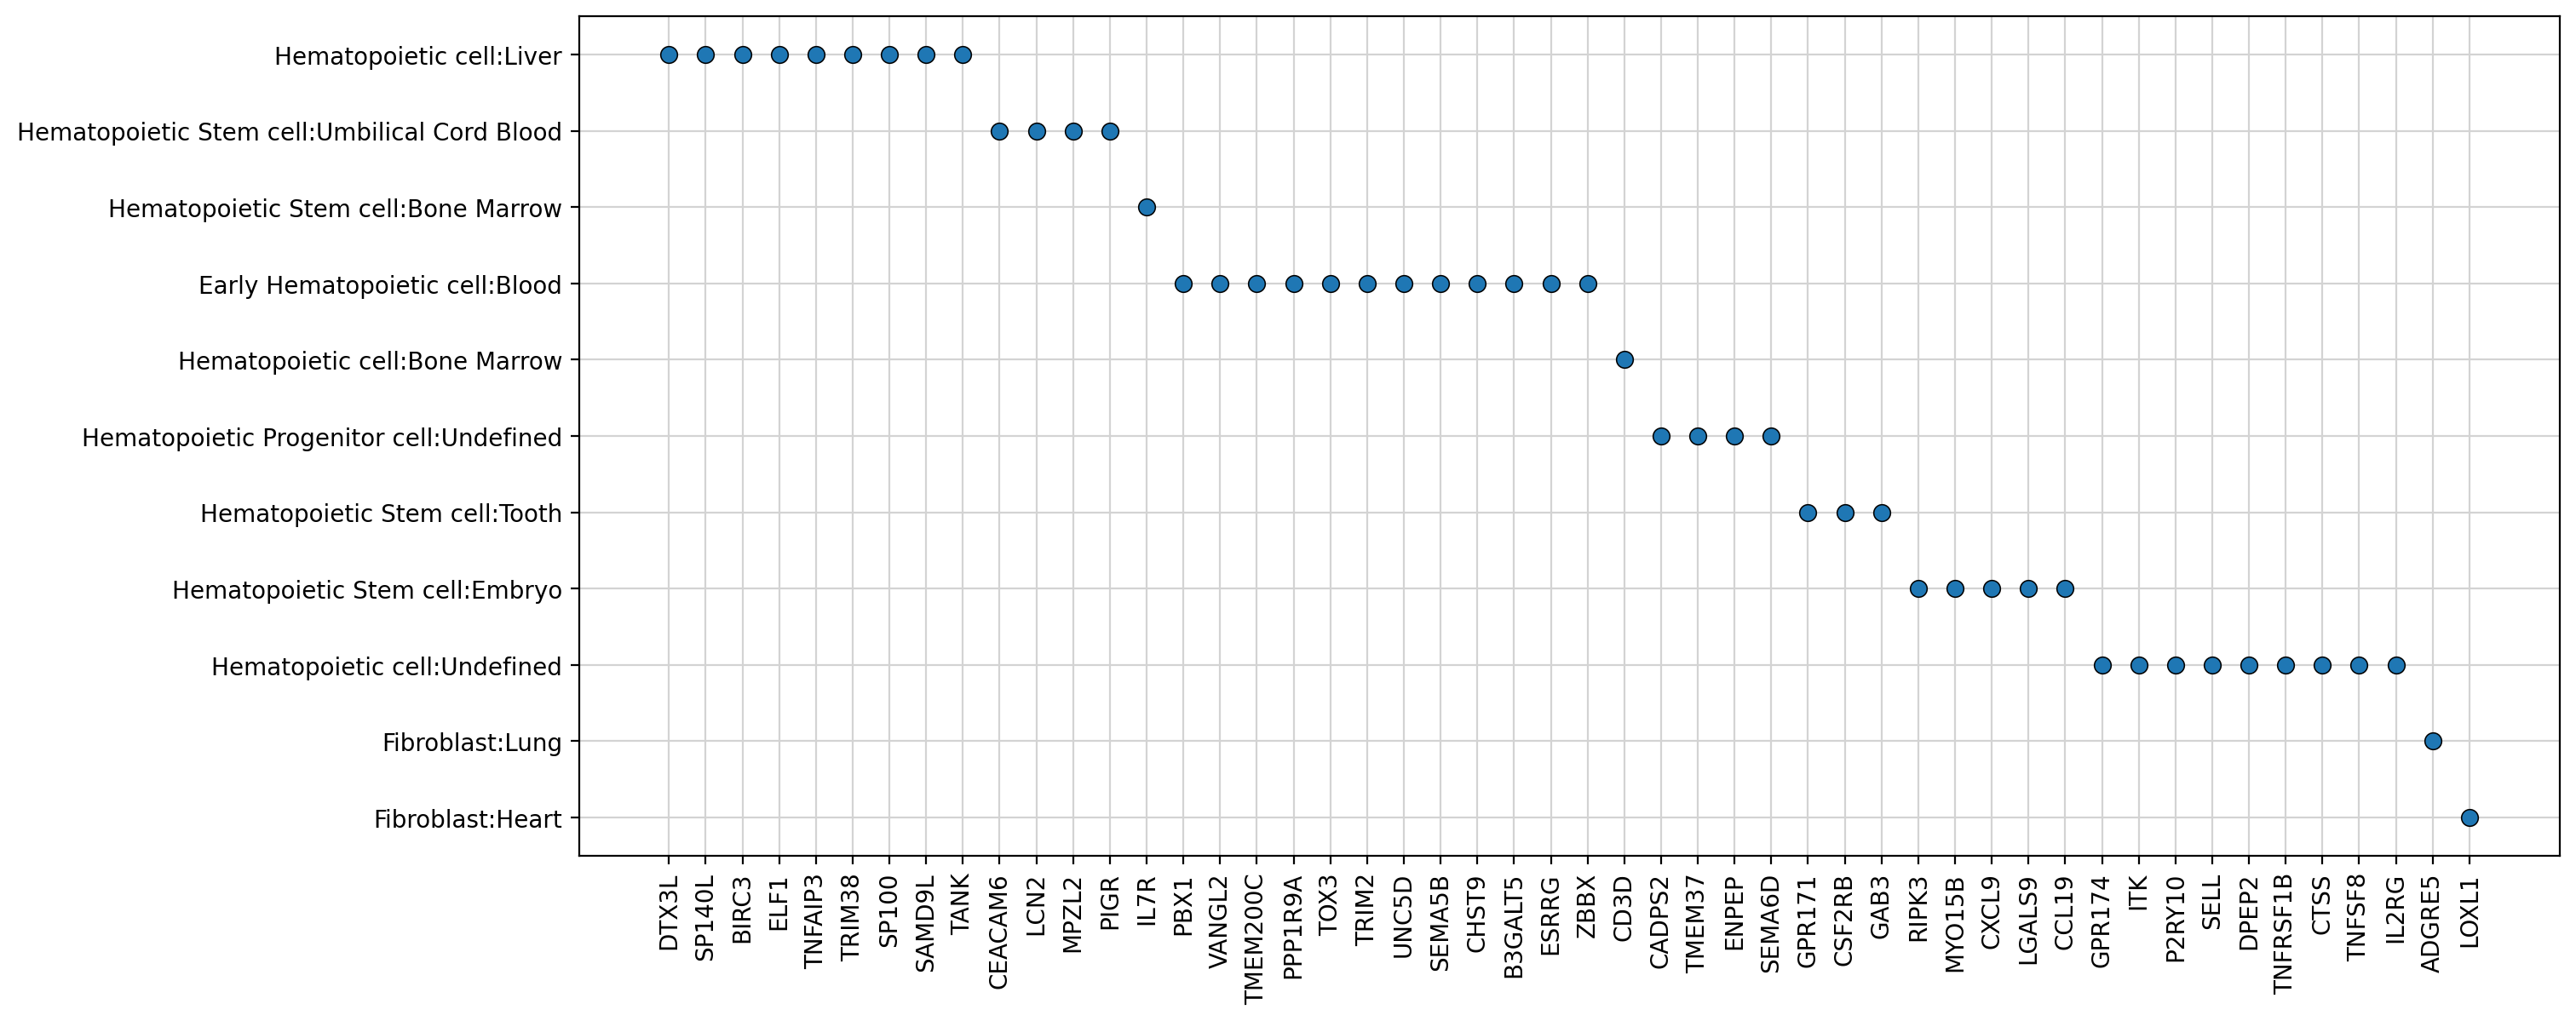

In [13]:
n_genes = 50
pdf = marker_gene_mat.copy()
pdf = pdf[~pdf.index.str.startswith("RP")]
pdf = pdf[~pdf.index.str.startswith("S100")]
pdf = pdf[~pdf.index.str.startswith("MT")]
print(f"{pdf.shape=}")

sorted_idx = np.argsort(pdf.sum(axis=1).values)
pdf = pdf.iloc[sorted_idx].astype(int)
pdf = pdf.head(n_genes).reset_index(names='gene_name') 
pdf = pd.melt(pdf, id_vars='gene_name')
pdf = pdf[pdf['value'] > 0]


plt.rcParams['figure.dpi'] = 200
sf = 5
x = n_genes
y =  marker_gene_mat.shape[1]
plt.rcParams['figure.figsize'] = (x / sf*1.5), (y / sf)

sns.scatterplot(
    data=pdf,
    x='gene_name',
    y='label',
    zorder=3,
    s=50,
    ec='k',
)

plt.grid(True, c='lightgrey', zorder=0)
plt.gca().tick_params(axis='x', rotation=90)
plt.xlabel("")
plt.ylabel("")

# Define the trainning data

In [14]:
exclude_datasets = [
    'iHSC',
    'sc_fib',
]

train_types= [
    'Fib',
    'HSC',
]

mask = (~adata.obs['dataset'].isin(exclude_datasets)) & (adata.obs['cell_type'].isin(train_types))
bdata = adata[mask, marker_gene_mat.index].copy()

# sc.pp.subsample(bdata, fraction=fraction)
sc.pp.filter_cells(bdata, min_genes=2)

# Split the data into training and testing sets
train_idx, test_idx = train_test_split(bdata.obs.index, test_size=0.2, random_state=42)

# Create AnnData objects for training and testing
train_data = bdata[train_idx, :].copy()
test_data = bdata[test_idx, :].copy()

print(train_data)
print()
print(test_data)

AnnData object with n_obs × n_vars = 37873 × 955
    obs: 'n_genes', 'dataset', 'n_genes_by_counts', 'total_counts', 'size_factor', 'obs_index', 'cell_type', 'standard_cell_type'
    var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'gene_id', 'token_id', 'gene_biotype', 'Chromosome', 'Start', 'End'
    layers: 'counts'

AnnData object with n_obs × n_vars = 9469 × 955
    obs: 'n_genes', 'dataset', 'n_genes_by_counts', 'total_counts', 'size_factor', 'obs_index', 'cell_type', 'standard_cell_type'
    var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'gene_id', 'token_id', 'gene_biotype', 'Chromosome', 'Start', 'End'
    layers: 'counts'


In [15]:
train_data.obs['cell_type'].value_counts()

cell_type
Fib    21227
HSC    16646
Name: count, dtype: int64

# Model config and Trainning

In [16]:
torch.cuda.empty_cache()
    
scvi.external.CellAssign.setup_anndata(
    train_data,
    size_factor_key="size_factor",
    # batch_key='dataset',
)

model = CellAssign(
    train_data, 
    marker_gene_mat.astype(int),
)

print("Done and ready for trainning!")

Done and ready for trainning!


In [17]:
torch.cuda.empty_cache()

start_time = time.time()  # Record the start time

model.train(
    max_epochs=50,
    lr=0.001,
    batch_size=200,
)

end_time = time.time()  # Record the end time
total_time = end_time - start_time  # Calculate total execution time

print(f"Training completed in {total_time:.2f} seconds")

# Optional: More detailed timing information
minutes = int(total_time // 60)
seconds = int(total_time % 60)
print(f"Training time: {minutes} minutes {seconds} seconds")

/home/cstansbu/miniconda3/envs/scanpy/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/cstansbu/miniconda3/envs/scanpy/lib/python3.12 ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/cstansbu/miniconda3/envs/scanpy/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/cstansbu/miniconda3/envs/scanpy/lib/python3.12 ...
You are using a CUDA device ('NVIDIA A100 80GB PCIe MIG 3g.40gb') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium'

Training:   0%|          | 0/50 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


Training completed in 305.64 seconds
Training time: 5 minutes 5 seconds


# Training Eval

In [18]:
metrics = pd.concat(
    model.history.values(), 
    ignore_index=False,
    axis=1
)

metrics = metrics.reset_index()
metrics.head()

,epoch,train_loss_step,validation_loss,elbo_validation,reconstruction_loss_validation,kl_local_validation,kl_global_validation,train_loss_epoch,elbo_train,reconstruction_loss_train,kl_local_train,kl_global_train
0,0,1298.103717,1305.958163,1306.660522,1305.870361,0.0,2992.265869,1401.137857,1401.137939,1401.04541,0.0,3154.319092
1,1,1151.62992,1124.665768,1125.297363,1124.586792,0.0,2690.933594,1178.540474,1178.540527,1178.457153,0.0,2841.20874
2,2,1092.173909,1002.377346,1002.941406,1002.306763,0.0,2403.295166,1032.771303,1032.77124,1032.696533,0.0,2546.631836
3,3,850.299501,917.033895,917.534912,916.971191,0.0,2134.73291,932.827125,932.826965,932.760437,0.0,2267.99292
4,4,800.692907,856.321577,856.766113,856.266052,0.0,1893.650024,862.370565,862.370667,862.311646,0.0,2012.082275


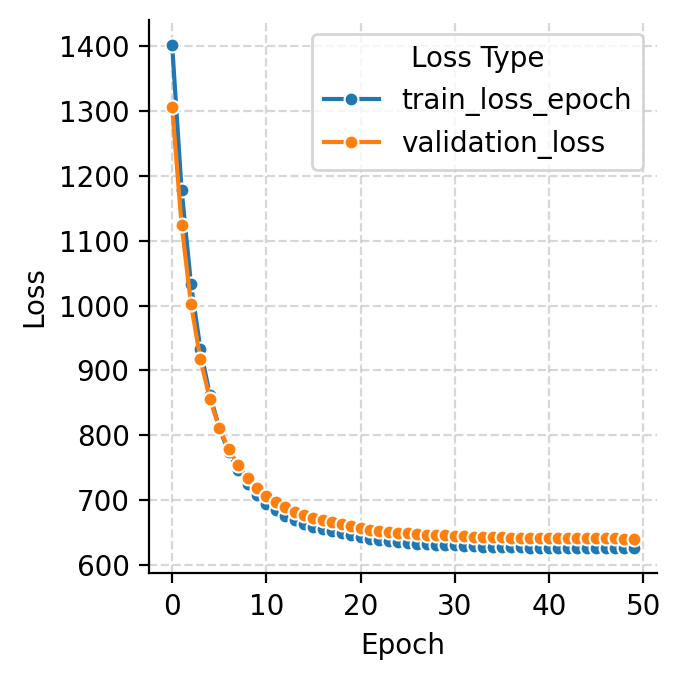

In [19]:
# Melt the DataFrame
df_melted = pd.melt(
    metrics,
    id_vars='epoch',
    value_vars=['train_loss_epoch', 'validation_loss'],
    var_name='Loss Type',  # More descriptive name
    value_name='Loss'      # More descriptive name
)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3.5, 3.5

sns.lineplot(
    data=df_melted,
    x='epoch',
    y='Loss',
    hue='Loss Type',
    palette=['#1f77b4', '#ff7f0e'],  # Use distinct colors
    linewidth=1.5,                  # Make lines thicker
    marker='o',                   # Add markers for data points
    markersize=5
)

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks()
plt.yticks()
plt.legend(title='Loss Type') 
plt.grid(True, linestyle='--', alpha=0.5)  # Add a subtle grid

sns.despine()

plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()

In [20]:
# break

# Prediction

In [21]:
torch.cuda.empty_cache()
predictions = model.predict()
predictions.head()

label,Hematopoietic cell:Liver,Hematopoietic Stem cell:Umbilical Cord Blood,Hematopoietic Progenitor cell:Umbilical Cord Blood,Hematopoietic Stem cell:Bone Marrow,Hematopoietic Stem cell:Breast,Early Hematopoietic cell:Blood,Hematopoietic Stem cell:Peripheral Blood,Hematopoietic cell:Bone Marrow,Hematopoietic Progenitor cell:Bone Marrow,Hematopoietic Stem cell:Corneal Endothelium,...,Fibroblast:Synovium,Fibroblast:Vocal Fold,Fibroblast:Corneal Endothelium,Fibroblast:Embryonic Stem Cell,Myofibroblast:Liver,Fibroblast:Lung,Myofibroblast:Undefined,Myofibroblast:Lung,Fibroblast:Peripheral Blood,Fibroblast:Heart
0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,2.095174e-241,0.000000e+00,0.000000e+00
1,3.097698e-288,7.256441e-268,1.201119e-203,9.255405e-268,1.030827e-249,2.707214e-271,1.607133e-215,8.687151e-263,6.652114e-215,1.912673e-246,...,4.875047e-152,2.078431e-263,7.239721e-100,1.003400e-155,1.000000e+00,5.434146e-259,2.056141e-115,2.256471e-69,4.286115e-93,6.906579e-266
2,1.793394e-56,2.026376e-43,1.457327e-48,3.889404e-40,9.593838e-50,1.059544e-43,1.540825e-51,8.542697e-38,6.645804e-51,4.473130e-50,...,9.366846e-50,6.246174e-39,1.080751e-49,1.223645e-47,5.600111e-51,1.279537e-40,1.936659e-54,1.078193e-52,5.403116e-50,5.126163e-59
3,8.966478e-84,1.244593e-63,7.144076e-74,4.265098e-68,6.725296e-66,1.905673e-69,1.475919e-77,6.254234e-63,2.252613e-76,2.851580e-66,...,2.854050e-51,2.301068e-65,4.211813e-50,6.775399e-52,1.000000e+00,1.072340e-62,1.115972e-55,6.905173e-16,3.088458e-29,1.807087e-61
4,2.785715e-318,4.743722e-319,8.103665e-320,2.388778e-304,0.000000e+00,0.000000e+00,4.446591e-323,2.943764e-289,1.476565e-319,0.000000e+00,...,0.000000e+00,5.547134e-288,0.000000e+00,0.000000e+00,0.000000e+00,2.646832e-286,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


In [22]:
# train_data.obs["scvi-tools predictions"] = predictions.idxmax(axis=1).values

# # celltype is the original CellAssign prediction
# sc.pl.umap(
#     train_data, 
#     color=["standard_cell_type", "scvi-tools predictions"], 
#     frameon=False, 
#     ncols=1,
# )

Text(0.5, 1.0, 'Training Data')

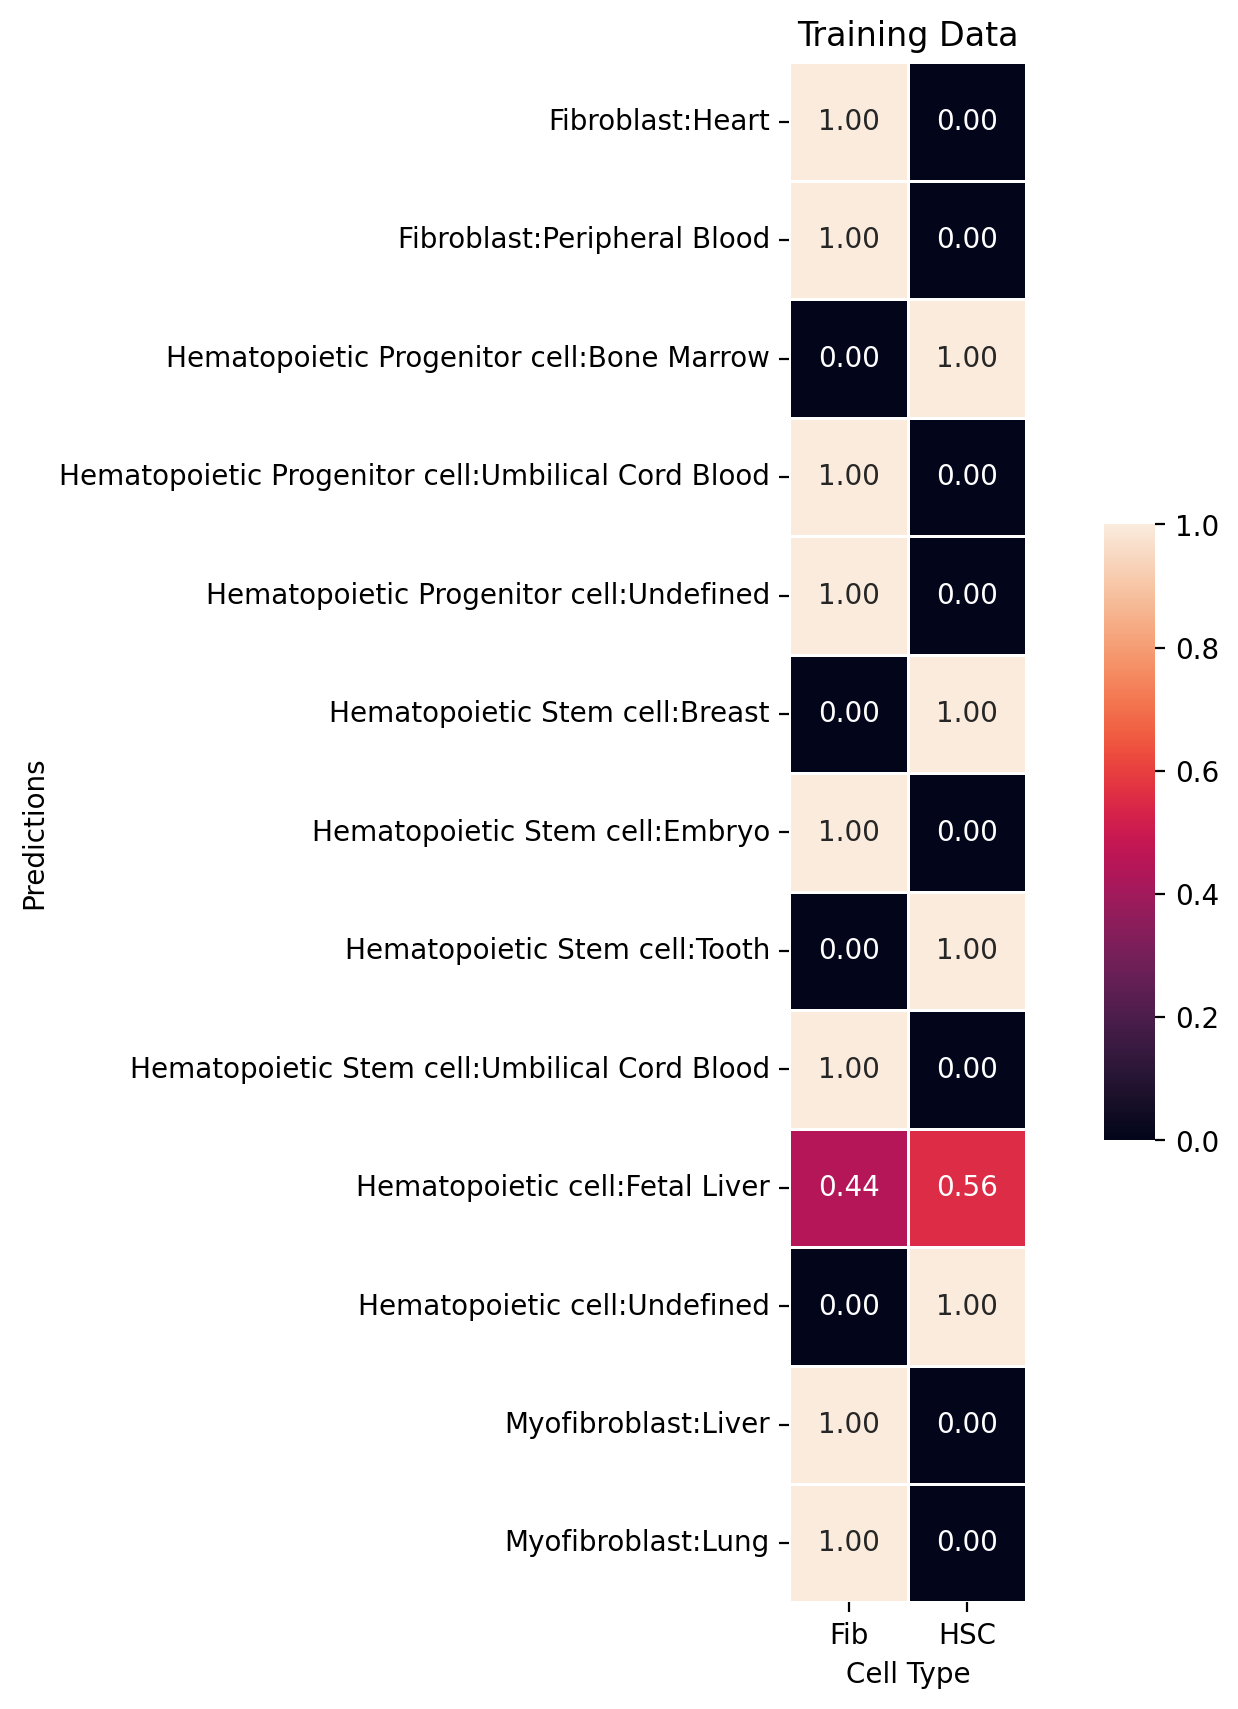

In [23]:
train_data.obs["predictions"] = predictions.idxmax(axis=1).values
df = train_data.obs
confusion_matrix = pd.crosstab(
    df["predictions"],
    df["cell_type"],
    rownames=["Predictions"],
    colnames=["Cell Type"],
)
confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)


plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 10, 10

sns.heatmap(
    confusion_matrix,
    square=True,
    cbar_kws=dict(shrink=0.4, aspect=12),
    annot=True,
    lw='1',
    fmt=".2f",
    # annot_kws=dict(fontsize=6),
)

plt.title('Training Data')

# Testing Data Validation 

In [24]:
def predict_other(adata, model):
    """Predict soft cell type assignment probability for each cell."""
    adata = model._validate_anndata(adata)
    scdl = model._make_data_loader(adata=adata)
    
    predictions = []
    for tensors in scdl:
        generative_inputs = model.module._get_generative_input(tensors, None)
        outputs = model.module.generative(**generative_inputs)
        gamma = outputs["gamma"]
        predictions += [gamma.cpu()]
    prob = pd.DataFrame(
        torch.cat(predictions).detach().numpy(), 
        columns=model.cell_type_markers.columns
    )
    prob['prediction'] = prob.idxmax(axis=1).values
    return prob


torch.cuda.empty_cache()
test_pred = predict_other(test_data, model)
test_pred['cell_type'] = test_data.obs['cell_type'].values

test_pred

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


OutOfMemoryError: CUDA out of memory. Tried to allocate 300.00 MiB. GPU 0 has a total capacity of 39.25 GiB of which 51.88 MiB is free. Including non-PyTorch memory, this process has 39.15 GiB memory in use. Of the allocated memory 38.75 GiB is allocated by PyTorch, and 204.61 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
confusion_matrix = pd.crosstab(
    test_pred["prediction"],
    test_pred["cell_type"],
    rownames=["Predictions"],
    colnames=["Cell Type"],
)
confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 10,10

sns.heatmap(
    confusion_matrix,
    square=True,
    cbar_kws=dict(shrink=0.4, aspect=12),
    annot=True,
    lw='1',
    fmt=".2f",
    # annot_kws=dict(fontsize=6),
)

plt.title('True Hold Out Data')

# Our data

In [ ]:
our_data = adata[adata.obs['dataset'].isin(exclude_datasets), marker_gene_mat.index].copy()
our_data

In [ ]:
pred = predict_other(our_data, model)
pred['cell_type'] = our_data.obs['cell_type'].values
pred['dataset'] = our_data.obs['dataset'].values

pred

In [ ]:
pred[['dataset', 'prediction']].value_counts()

In [ ]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 6, 3

sns.barplot(
    pred[cell_types].mean(axis=0).sort_values(ascending=False),
    ec='k'
)

plt.gca().tick_params(axis='x', rotation=90)

In [ ]:
break